In [1]:
import pandas as pd

# Visualizando os dados

In [2]:
df_train = pd.read_csv('sales_train.csv', sep=',')
df_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [3]:
# a coluna item_cnt_day não pode conter valores negativos pois representa a quantidade de produtos vendidos. Deve haver erros nessa coluna, então isso deve ser consertado.

# função para transformar um numero negativo em positivo

def positive (num):
    
    if num < 0:
        num = num*(-1)
        
    return num

# aplicando a função na coluna

df_train['item_cnt_day'] = df_train['item_cnt_day'].apply(positive)
df_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [7]:
df_train.shape

(2935849, 6)

In [4]:
df_test = pd.read_csv('test.csv', sep=',')
df_test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [5]:
df_items = pd.read_csv('items.csv', sep=',')
df_items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [5]:
df_item_categories = pd.read_csv('item_categories.csv', sep=',')
df_item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [6]:
df_shops = pd.read_csv('shops.csv', sep=',')
df_shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


# Exploração dos dados de treino

Ações de exploração dos dados:

* Categorizar os meses que mais venderam
* Categorizar os itens que mais venderam (por dia, por mês)
* Categorizar as categorias de itens que mais venderam
* Verificar se existe relação entre o valor do item e o volume de saídas
* Describe na coluna de item_cnt_day
* Categorizar as vendas por shop

# Colocando os dados em tremos das quantidades mensais de saídas

Como a quantidade a ser prevista no desafio é o volume de vendas mensal, então o que faz mais sentido é analisar os dados em termos das quantidades mensais de vendas. É preciso ter a informação de saída de cada item em um determinado mês.

In [6]:
group = pd.DataFrame(df_train.groupby(['item_id', 'date_block_num'])['item_cnt_day'].sum().rename('monthly_label'))
group.head()

monthly_label
item_id date_block_num               
0       20                        1.0
1       15                        2.0
        18                        1.0
        19                        1.0
        20                        1.0

In [18]:
group['monthly_label'].describe()

count    233912.000000
mean         15.596489
std          96.125890
min         -22.000000
25%           2.000000
50%           4.000000
75%          11.000000
max       12557.000000
Name: monthly_label, dtype: float64

In [19]:
group.shape

(233912, 1)

In [7]:
df_prices = df_train[['item_id', 'date_block_num', 'item_price']]
df_prices.head()

,item_id,date_block_num,item_price
0,22154,0,999.00
1,2552,0,899.00
2,2552,0,899.00
3,2554,0,1709.05
4,2555,0,1099.00


In [11]:
df_prices.shape

(2935849, 3)

In [8]:
# juntar os dataframes 'group' e 'df_prices' avaliar a correlação entre preço e vendas

prices = pd.merge(group, df_prices, on=['item_id', 'date_block_num'])
prices.head()

,item_id,date_block_num,monthly_label,item_price
0,0,20,1.0,58.0
1,1,15,2.0,4490.0
2,1,15,2.0,4490.0
3,1,18,1.0,4490.0
4,1,19,1.0,4490.0


In [14]:
prices.shape

(2935849, 4)

In [9]:
# é preciso deletar as informações duplicadas de um mesmo item em um mesmo mês. O que interessa é somente a informação de cada item em cada mês
prices = prices.drop_duplicates(subset =['item_id', 'date_block_num'])
prices.shape

(233912, 4)

In [11]:
# analisando a correlação entre preço e volume de saídas

prices['item_price'].corr(prices['monthly_label'])

0.026414794661615153

In [17]:
prices['item_price'].describe()

count    233912.000000
mean        747.676566
std        1540.748655
min           5.000000
25%         199.000000
50%         349.000000
75%         799.000000
max      307980.000000
Name: item_price, dtype: float64

In [26]:
# pegando apenas os dados entre os percentis 25% e 75% da coluna de preços para fazer uma análise gráfica mais detalhada da relação entre preço e volume de saída

import numpy as np

# Find out percentiles
lower = np.percentile(prices['item_price'], 25)
upper = np.percentile(prices['item_price'], 75)

# Select data between
trimmed = prices[prices.item_price.between(lower, upper)]
trimmed.head()

,item_id,date_block_num,monthly_label,item_price
20,12,1,1.0,189.0
73,27,16,1.0,498.0
74,27,17,3.0,498.0
77,28,0,8.0,549.0
85,28,1,8.0,398.0


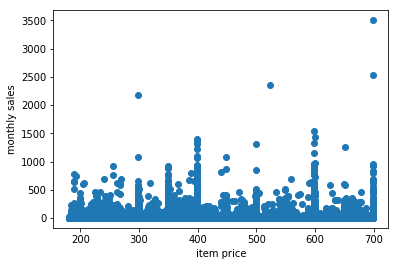

In [29]:
# analisando graficamente a relação entre preço e volume de vendas mensal olhando para os dados entre os percentis 25% e 75% da coluna de preços dos itens

%matplotlib inline
import matplotlib.pyplot as plt

x = trimmed['item_price'].tolist()
y = trimmed['monthly_label'].tolist()

plt.scatter(x, y)
plt.xlabel('item price')
plt.ylabel('monthly sales')
plt.show()

In [10]:
shop = df_train[['item_id', 'date_block_num', 'shop_id']]

In [11]:
# juntar os dataframes 'prices' e 'shop' para agregar a coluna shop_id

data = pd.merge(prices, shop, on=['item_id', 'date_block_num'])
data.head()

,item_id,date_block_num,monthly_label,item_price,shop_id
0,0,20,1.0,58.0,54
1,1,15,2.0,4490.0,55
2,1,15,2.0,4490.0,55
3,1,18,1.0,4490.0,55
4,1,19,1.0,4490.0,55


In [12]:
# é preciso deletar as informações duplicadas de um mesmo item em um mesmo mês. O que interessa é somente a informação de cada item em cada mês
data = data.drop_duplicates(subset =['item_id', 'date_block_num'])
data.shape

(233912, 5)

In [13]:
category = df_items[['item_id', 'item_category_id']]

In [14]:
# agregando a coluna 'item_category_id' ao dataframe

data_train = pd.merge(data, category, on=['item_id'])
data_train.shape

(233912, 6)

In [15]:
data_train = data_train[['item_id', 'item_category_id', 'date_block_num', 'item_price', 'shop_id', 'monthly_label']]
data_train.head()

,item_id,item_category_id,date_block_num,item_price,shop_id,monthly_label
0,0,40,20,58.0,54,1.0
1,1,76,15,4490.0,55,2.0
2,1,76,18,4490.0,55,1.0
3,1,76,19,4490.0,55,1.0
4,1,76,20,4490.0,55,1.0


# Exploração dos dados de treino

## Agora que a base foi estruturada da maneira correta, é possível realizar uma análise exploratória dos dados

Ações de exploração dos dados:

* Categorizar os meses que mais venderam
* Categorizar os itens que mais venderam (por dia, por mês)
* Categorizar as categorias de itens que mais venderam
* Verificar se existe relação entre o valor do item e o volume de saídas
* Describe na coluna de item_cnt_day
* Categorizar as vendas por shop

In [20]:
# gerando relatório para ter uma visão geral dos dados

import pandas_profiling

profile = data_train.profile_report(title='Pandas Profiling Report')
profile.to_file(output_file="Monthly Sales data profiling.html")

In [19]:
# analisando os dados em termos das quantidades de vendas mensais
data_train.sort_values(by='monthly_label', ascending=False).head(50)

,item_id,item_category_id,date_block_num,item_price,shop_id,monthly_label
222759,20949,71,11,5.000000,25,12557.0
222771,20949,71,23,5.000000,43,12185.0
222758,20949,71,10,5.000000,27,8537.0
222753,20949,71,5,5.000000,30,8424.0
222756,20949,71,8,5.000000,50,7945.0
222772,20949,71,24,5.000000,27,7871.0
222757,20949,71,9,5.000000,41,7738.0
222770,20949,71,22,5.000000,31,7721.0
222762,20949,71,14,5.000000,50,7717.0
222760,20949,71,12,5.000000,54,7329.0


In [20]:
# conclusões da célula acima

# o item 20949 é o que mais vende
# não existe uma preponderância de maior número de vendas entre os shoppings
# aparentemente os itens da categoria 71 são os que mais vendem. para ter uma melhor visão, é preciso verificar a proporção de itens existentes de cada categoria

count_categories = pd.DataFrame(data_train.groupby('item_category_id')['item_category_id'].count().rename('quantidade'))
count_categories.sort_values(by='quantidade', ascending=False).head()

#Conclusão: os itens da categoria 71 são de fato os que mais vendem

,quantidade
item_category_id,
40,53614
55,33363
37,24427
31,8390
30,8150


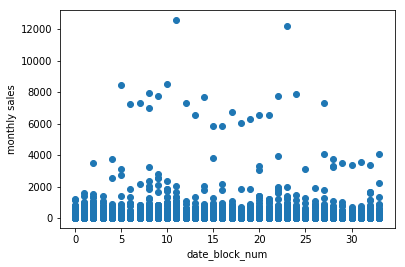

In [23]:
# analisando graficamente a relação entre os meses e o volume de vendas mensal
%matplotlib inline
import matplotlib.pyplot as plt

x = data_train['date_block_num'].tolist()
y = data_train['monthly_label'].tolist()

plt.scatter(x, y)
plt.xlabel('date_block_num')
plt.ylabel('monthly sales')
plt.show()

# Configurando a base de testes para conter todas as features necessárias, bem como na base de treino

In [16]:
feat = data_train[['item_id', 'item_category_id', 'item_price']]

data_test = pd.merge(feat, df_test, on=['item_id'])
data_test.shape

(2924544, 5)

In [17]:
data_test.head()

,item_id,item_category_id,item_price,ID,shop_id
0,30,40,399.0,2587,5
1,30,40,399.0,7687,4
2,30,40,399.0,12787,6
3,30,40,399.0,17887,3
4,30,40,399.0,22987,2


In [17]:
# a previsão é para o mês de novembro de 2015, então a coluna 'date_block_num' será 34 em todas as linhas para a base de testes

data_test['dat_block_num'] = 34
data_test.head()

,item_id,item_category_id,item_price,ID,shop_id,dat_block_num
0,30,40,399.0,2587,5,34
1,30,40,399.0,7687,4,34
2,30,40,399.0,12787,6,34
3,30,40,399.0,17887,3,34
4,30,40,399.0,22987,2,34


In [19]:
data_test.head()

,item_id,item_category_id,item_price,ID,shop_id,dat_block_num
0,30,40,399.0,2587,5,34
1,30,40,399.0,7687,4,34
2,30,40,399.0,12787,6,34
3,30,40,399.0,17887,3,34
4,30,40,399.0,22987,2,34


In [18]:
# não precisamos de duas previsões para o mesmo item no mesmo shopping, então vamos dropar as linhas em que há duplicados nesses dois campos

data_test = data_test.drop_duplicates(subset =['item_id', 'shop_id'])
data_test.shape



(198954, 6)

In [21]:
data_test.head()

# a base está pronta para o modelo

,item_id,item_category_id,item_price,ID,shop_id,dat_block_num
0,30,40,399.0,2587,5,34
1,30,40,399.0,7687,4,34
2,30,40,399.0,12787,6,34
3,30,40,399.0,17887,3,34
4,30,40,399.0,22987,2,34


In [19]:
data_test = data_test[['ID', 'item_id', 'item_category_id', 'dat_block_num', 'item_price', 'shop_id']]
data_test.head()

,ID,item_id,item_category_id,dat_block_num,item_price,shop_id
0,2587,30,40,34,399.0,5
1,7687,30,40,34,399.0,4
2,12787,30,40,34,399.0,6
3,17887,30,40,34,399.0,3
4,22987,30,40,34,399.0,2


# Inicializando o spark para fazer a preparação dos dados

In [16]:
import os
exec(open(os.path.join(os.environ["SPARK_HOME"], 'python/pyspark/shell.py')).read())

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 2.4.3
      /_/

Using Python version 3.7.1 (default, Dec 10 2018 22:54:23)
SparkSession available as 'spark'.


In [17]:
# criando uma session para fazer a conversão de um pandas dataframe em um spark dataframe
from pyspark.sql import SparkSession
import pyspark.sql.functions as sqlfunc
from pyspark.sql.types import *
import argparse, sys
from pyspark.sql import *
import pyspark.sql.functions as sqlfunc

def create_session(appname):
    spark_session = SparkSession\
        .builder\
        .appName(appname)\
        .master('yarn')\
        .config("hive.metastore.uris", "thrift://uds-far-mn1.dab.02.net:9083")\
        .enableHiveSupport()\
        .getOrCreate()
    return spark_session
### START MAIN ###
if __name__ == '__main__':
    spark_session = create_session('testing_files')

In [18]:
# transformando a base de treino em um spark dataframe

df_train = spark_session.createDataFrame(data_train)
df_train.show(3)

+-------+----------------+--------------+----------+-------+-------------+
|item_id|item_category_id|date_block_num|item_price|shop_id|monthly_label|
+-------+----------------+--------------+----------+-------+-------------+
|      0|              40|            20|      58.0|     54|          1.0|
|      1|              76|            15|    4490.0|     55|          2.0|
|      1|              76|            18|    4490.0|     55|          1.0|
+-------+----------------+--------------+----------+-------+-------------+
only showing top 3 rows



In [19]:
df_train = df_train.drop('item_id')
df_train.show(3)

+----------------+--------------+----------+-------+-------------+
|item_category_id|date_block_num|item_price|shop_id|monthly_label|
+----------------+--------------+----------+-------+-------------+
|              40|            20|      58.0|     54|          1.0|
|              76|            15|    4490.0|     55|          2.0|
|              76|            18|    4490.0|     55|          1.0|
+----------------+--------------+----------+-------+-------------+
only showing top 3 rows



In [20]:
# as colunas 'item_category_id' e 'shop_id' precisam de um encode pq tratam-se de variáveis categóricas

from pyspark.ml.feature import OneHotEncoderEstimator

encoder = OneHotEncoderEstimator(inputCols=["item_category_id", "shop_id"], outputCols=["category_encoded", "shop_encoded"])
model = encoder.fit(df_train)
encoded_train = model.transform(df_train)
encoded_train.printSchema()

root
 |-- item_category_id: long (nullable = true)
 |-- date_block_num: long (nullable = true)
 |-- item_price: double (nullable = true)
 |-- shop_id: long (nullable = true)
 |-- monthly_label: double (nullable = true)
 |-- category_encoded: vector (nullable = true)
 |-- shop_encoded: vector (nullable = true)



In [21]:
# dropando as colunas que receberam o encode

encoded_train = encoded_train.drop('item_category_id', 'shop_id')
encoded_train.printSchema()

root
 |-- date_block_num: long (nullable = true)
 |-- item_price: double (nullable = true)
 |-- monthly_label: double (nullable = true)
 |-- category_encoded: vector (nullable = true)
 |-- shop_encoded: vector (nullable = true)



In [22]:
encoded_train.show(3)

+--------------+----------+-------------+----------------+---------------+
|date_block_num|item_price|monthly_label|category_encoded|   shop_encoded|
+--------------+----------+-------------+----------------+---------------+
|            20|      58.0|          1.0| (83,[40],[1.0])|(59,[54],[1.0])|
|            15|    4490.0|          2.0| (83,[76],[1.0])|(59,[55],[1.0])|
|            18|    4490.0|          1.0| (83,[76],[1.0])|(59,[55],[1.0])|
+--------------+----------+-------------+----------------+---------------+
only showing top 3 rows



In [23]:
# criando o vetor de features

from pyspark.ml.feature import VectorAssembler

vectorAssembler = VectorAssembler(inputCols = ['date_block_num', 'item_price', 'category_encoded', 'shop_encoded'], outputCol = 'features')
vtrain = vectorAssembler.transform(encoded_train)
vtrain = vtrain.select(['features', 'monthly_label'])
vtrain.show(3)

+--------------------+-------------+
|            features|monthly_label|
+--------------------+-------------+
|(144,[0,1,42,139]...|          1.0|
|(144,[0,1,78,140]...|          2.0|
|(144,[0,1,78,140]...|          1.0|
+--------------------+-------------+
only showing top 3 rows



In [28]:
# transformando a base de testes em um spark dataframe

df_test = spark_session.createDataFrame(data_test)
df_test.show(3)

+-----+-------+----------------+-------------+----------+-------+
|   ID|item_id|item_category_id|dat_block_num|item_price|shop_id|
+-----+-------+----------------+-------------+----------+-------+
| 2587|     30|              40|           34|     399.0|      5|
| 7687|     30|              40|           34|     399.0|      4|
|12787|     30|              40|           34|     399.0|      6|
+-----+-------+----------------+-------------+----------+-------+
only showing top 3 rows



In [29]:
df_test = df_test.drop('ID', 'item_id')

In [30]:
# as colunas 'item_category_id' e 'shop_id' precisam de um encode pq tratam-se de variáveis categóricas

enc = OneHotEncoderEstimator(inputCols=["item_category_id", "shop_id"], outputCols=["category_encoded", "shop_encoded"])
mod = enc.fit(df_test)
encoded_test = mod.transform(df_test)
encoded_test.printSchema()

root
 |-- item_category_id: long (nullable = true)
 |-- dat_block_num: long (nullable = true)
 |-- item_price: double (nullable = true)
 |-- shop_id: long (nullable = true)
 |-- category_encoded: vector (nullable = true)
 |-- shop_encoded: vector (nullable = true)



In [31]:
# dropando as colunas que receberam o encode

encoded_test = encoded_test.drop('item_category_id', 'shop_id')
encoded_test.show(3)

+-------------+----------+----------------+--------------+
|dat_block_num|item_price|category_encoded|  shop_encoded|
+-------------+----------+----------------+--------------+
|           34|     399.0| (83,[40],[1.0])|(59,[5],[1.0])|
|           34|     399.0| (83,[40],[1.0])|(59,[4],[1.0])|
|           34|     399.0| (83,[40],[1.0])|(59,[6],[1.0])|
+-------------+----------+----------------+--------------+
only showing top 3 rows



In [32]:
# criando o vetor de features na base de testes

vectorAssembler = VectorAssembler(inputCols = ['dat_block_num', 'item_price', 'category_encoded', 'shop_encoded'], outputCol = 'features')
vtest = vectorAssembler.transform(encoded_test)
vtest = vtest.select('features')
vtest.show(3)

+--------------------+
|            features|
+--------------------+
|(144,[0,1,42,90],...|
|(144,[0,1,42,89],...|
|(144,[0,1,42,91],...|
+--------------------+
only showing top 3 rows



# Aplicação do modelo de regressão do Random Forest na base de treinos e analisar previsões supervisionadas


In [24]:
# dividindo a base de treino

(trainingA, trainingB) = vtrain.randomSplit([0.8, 0.2])

In [25]:
# aplicando o modelo na base de treino

from pyspark.ml.regression import RandomForestRegressor

# Cria o modelo para Classificação com 10 árvores
forest = RandomForestRegressor ( featuresCol = 'features', labelCol = 'monthly_label', numTrees=10 )
forestModel = forest.fit ( trainingA )

supervisioned_predictions = forestModel.transform ( trainingB )

In [26]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol="monthly_label", predictionCol="prediction", metricName="rmse")

rmse = evaluator.evaluate(supervisioned_predictions)

print(rmse)

57.08206572861665


Text(0.5, 1.0, 'Feature Importances')

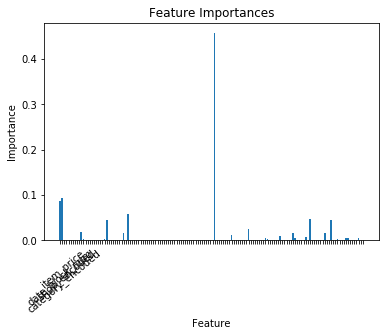

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt

importances = forestModel.featureImportances

x_values = list(range(len(importances)))
feature_list = ['date_block_num', 'item_price', 'category_encoded', 'shop_encoded']

plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation=40)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')

In [76]:
supervisioned_predictions.show(30)

+--------------------+-------------+------------------+
|            features|monthly_label|        prediction|
+--------------------+-------------+------------------+
|(144,[0,1,4],[23....|          9.0|14.764874319038759|
|(144,[0,1,4],[32....|          5.0|14.764874319038759|
|(144,[0,1,4,87],[...|         10.0|14.764874319038759|
|(144,[0,1,4,87],[...|          2.0|14.764874319038759|
|(144,[0,1,4,87],[...|          3.0|14.764874319038759|
|(144,[0,1,4,87],[...|          2.0|14.764874319038759|
|(144,[0,1,4,87],[...|          1.0|14.764874319038759|
|(144,[0,1,4,88],[...|          1.0|11.142994279844942|
|(144,[0,1,4,88],[...|          6.0|14.764874319038759|
|(144,[0,1,4,89],[...|          1.0|14.764874319038759|
|(144,[0,1,4,89],[...|         43.0|14.764874319038759|
|(144,[0,1,4,89],[...|          6.0|14.764874319038759|
|(144,[0,1,4,90],[...|          1.0|14.764874319038759|
|(144,[0,1,4,91],[...|          4.0|14.764874319038759|
|(144,[0,1,4,92],[...|          1.0|14.764874319

NameError: name 'importances' is not defined

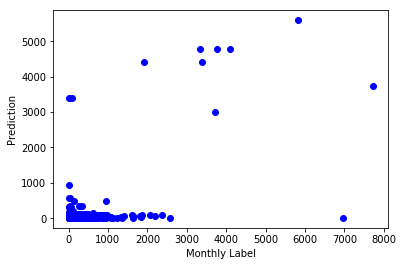

In [39]:
# visualizando a predição x valores reais

%matplotlib inline
import matplotlib.pyplot as plt

rfResult = supervisioned_predictions.toPandas()

plt.plot(rfResult.monthly_label, rfResult.prediction, 'bo')
plt.xlabel('Monthly Label')
plt.ylabel('Prediction')
plt.show()

In [40]:
# conclusão da célula acima: o modelo tá muito ruim!

# Aplicando o modelo de resgressão linear

In [27]:
from pyspark.ml.regression import LinearRegression

# Cria o modelo
linearRegression = LinearRegression(featuresCol='features', labelCol='monthly_label')

# Treina o modelo com a base de treinamento (data frame formatado)
lrModel = linearRegression.fit(trainingA)

# Aplica o modelo treinado para predizer a saída (label) na base de testes
pred = lrModel.transform(trainingB)

In [28]:
# avaliando o erro médio quadrático e o r2 na base de treinos

trainingSummary = lrModel.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 75.089249
r2: 0.432305


In [29]:
# avaliando o erro médio quadrático na base onde as previsões supervisionadas foram feitas

evaluator = RegressionEvaluator(labelCol="monthly_label", predictionCol="prediction", metricName="rmse")

rmse = evaluator.evaluate(pred)

print(rmse)

67.65988426414201


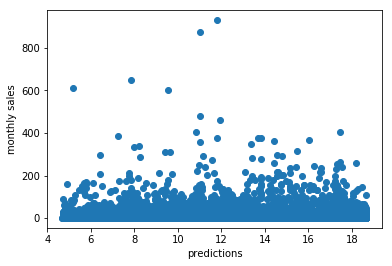

In [32]:
# visualizando a predição x valores reais entre os percentis de 25% a 75% dos valores

# pegando os valores entre os percentis
import numpy as np

pred_pandas = pred.toPandas()

# Find out percentiles
lower = np.percentile(pred_pandas['prediction'], 25)
upper = np.percentile(pred_pandas['prediction'], 75)

# Select data between
trimmed = pred_pandas[pred_pandas.prediction.between(lower, upper)]

# configurando o gráfico
%matplotlib inline
import matplotlib.pyplot as plt

x = trimmed['prediction'].tolist()
y = trimmed['monthly_label'].tolist()

plt.scatter(x, y)
plt.xlabel('predictions')
plt.ylabel('monthly sales')
plt.show()

In [73]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import HashingTF, Tokenizer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Configure an ML pipeline, which consists of tree stages: tokenizer, hashingTF, and lr.
lr = LogisticRegression(maxIter=10)
pipeline = Pipeline(stages=[vtrain, lr])

# We now treat the Pipeline as an Estimator, wrapping it in a CrossValidator instance.
# This will allow us to jointly choose parameters for all Pipeline stages.
# A CrossValidator requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
# We use a ParamGridBuilder to construct a grid of parameters to search over.
# With 3 values for hashingTF.numFeatures and 2 values for lr.regParam,
# this grid will have 3 x 2 = 6 parameter settings for CrossValidator to choose from.
paramGrid = ParamGridBuilder() \
    .addGrid(hashingTF.numFeatures, [10, 100, 1000]) \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(),
                          numFolds=3)  # use 3+ folds in practice

# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(trainingA)

AttributeError: 'DataFrame' object has no attribute 'copy'